### Import Libraries

In [1]:
import sys

sys.path.append('..')

In [29]:
import utils.data
import utils.trans
import utils.extract
import utils.visualize
import utils.features
import utils.models
import utils.models_utils

In [30]:
from importlib import reload

In [154]:
reload(utils.data)
reload(utils.trans)
reload(utils.extract)
reload(utils.visualize)
reload(utils.features)
reload(utils.models)
reload(utils.models_utils)

<module 'utils.models_utils' from '..\\utils\\models_utils.py'>

### Load Data

In [5]:
import pandas as pd
import librosa
from pathlib import Path
from tqdm import tqdm_notebook as tqdm

In [6]:
dir_path_str = "..\\..\\datasets\\audio\\audio_speech_actors"

In [7]:
df_files = utils.data.files_dataframe(dir_path_str)
file_path_str_list = df_files['path'].values

1440 files were found


In [8]:
file_path_str_list = file_path_str_list[:400]

In [9]:
x_wave_list, f_s_list = utils.data.load_wave_files(file_path_str_list)

In [10]:
# x = {}
# x['wave'] = utils.data.load_wave(file_path)

### Frequency Transforms

In [32]:
trans_func = utils.trans.wave_to_cqt # utils.trans.wave_to_mel # 
trans_params = utils.extract.params['cqt'] # utils.extract.params['mel'] # 

In [34]:
x_list = []
with tqdm(total=len(file_path_str_list), unit='file') as pbar:
    for wave in x_wave_list:
        x = trans_func(wave, **trans_params)
        x_list.append(x)
        pbar.update()

In [35]:
utils.visualize.display_shapes(x_list[0])   

x:
--s: (2048, 620)
--c: (300, 620)
--f_phase: (2048, 620)
--f: (2048,)
--t: (620,)


### View Example

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio

In [37]:
figsize = (15, 2)
# figsize = (15, 5)
cmap_spec = 'magma'

In [38]:
# utils.visualize.display_all(x, figsize=figsize, cmap_spec=cmap_spec, 
#                             display_rainbowgrams=True,
#                             display_cepstrum=True)

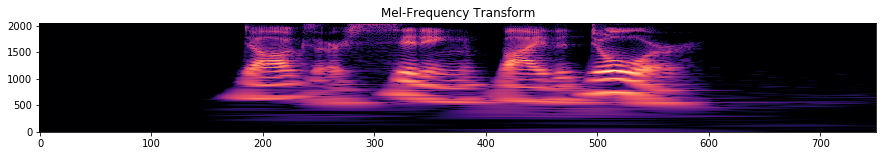

In [52]:
idx = np.random.randint(len(x_list))
x_wave = x_wave_list[idx]
x = x_list[idx]


# sound wave:
display(Audio(x_wave, rate=utils.extract.f_s))

# # display wave:
# plt.figure(figsize=figsize)
# plt.plot(x_wave)
# # plt.plot(x['wave']['t'], x['wave']['s'])
# # plt.xlim(x['wave']['t'][[0, -1]])
# # plt.xticks(axes['wave']['t']['val'], axes['wave']['t']['val'])
# # plt.xlabel('t [sec]')
# plt.title('Waveform')
# plt.show()

# display mel:
plt.figure(figsize=figsize)
plt.imshow(x['s'], origin='lower', aspect='auto', cmap=cmap_spec)
# plt.xticks(axes['mel']['t']['idx'], axes['mel']['t']['val'])
# plt.yticks(axes['mel']['f']['idx'], axes['mel']['f']['val'])
# plt.xlabel('t [sec]')
# plt.ylabel('f [KHz]')
plt.title('Mel-Frequency Transform')
plt.show()

# # display rms:
# plt.figure(figsize=figsize)
# plt.plot(np.mean(x['s'], axis=0))
# plt.title('Energy')
# plt.show()

### Pre-Processing

In [53]:
x_length = np.array([x['s'].shape[1] for x in x_list])
min_length = np.min(x_length)
x_stack_cut = np.array([x['s'][:, :min_length] for x in x_list])

x_mean = np.mean(x_stack_cut, axis=0)
x_energy = np.mean(x_stack_cut, axis=(0, 1))
idx_to_keep = x_energy > 0.03

x_stack = x_stack_cut[:, :, idx_to_keep]

In [56]:
# x_stack = x_stack[:, 512:, :]

In [57]:
print(x_stack_cut.shape)
print(x_stack.shape)

(400, 2048, 576)
(400, 1536, 433)


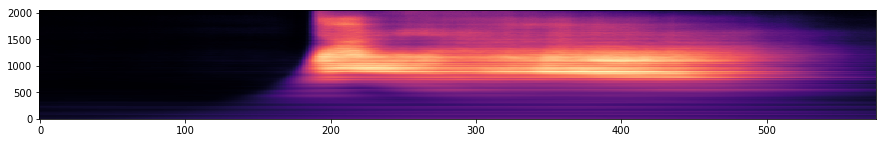

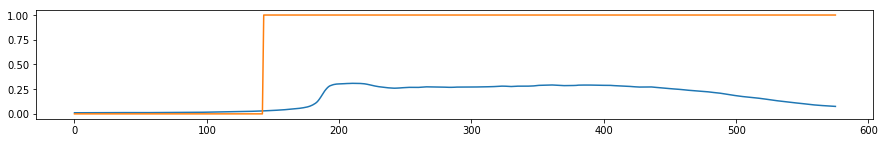

In [58]:
plt.figure(figsize=figsize)
plt.imshow(x_mean, origin='lower', aspect='auto', cmap=cmap_spec)
plt.show()

plt.figure(figsize=figsize)
plt.plot(x_energy)
plt.plot(idx_to_keep)
plt.show()

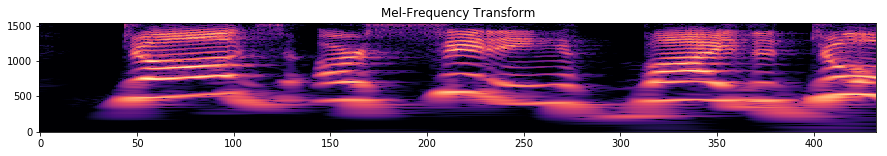

In [64]:
idx = np.random.randint(len(x_list))

display(Audio(x_wave_list[idx], rate=utils.extract.f_s))

plt.figure(figsize=figsize)
plt.imshow(x_stack[idx], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('Mel-Frequency Transform')
plt.show()

In [65]:
n_window = 128 # 32 # 16 # 
n_overlap = 0
n_hop = n_window-n_overlap

idx_windows = librosa.util.frame(np.arange(x_stack.shape[2]), frame_length=n_window, hop_length=n_hop)

In [66]:
idx_windows.shape

(128, 3)

In [67]:
x_windows = x_stack[:, :, idx_windows]
x_windows_transposed = x_windows.transpose((0,3,1,2))

In [68]:
x_windows_transposed.shape

(400, 3, 1536, 128)

In [69]:
x_data = np.concatenate(x_windows_transposed, axis=0)

In [70]:
x_data.shape

(1200, 1536, 128)

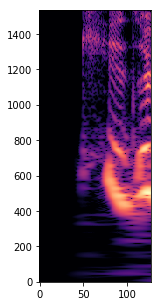

In [71]:
idx = np.random.randint(len(x_data))

plt.figure(figsize=(2, 5))
plt.imshow(x_data[idx], origin='lower', aspect='auto', cmap=cmap_spec)
plt.show()

### Train Model

In [112]:
import keras
from keras.layers import *
from keras.engine import Model
from keras.optimizers import SGD

In [73]:
# reshape_data:

x_data_reshaped = np.expand_dims(x_data, axis=3)

print(x_data_reshaped.shape)

(1200, 1536, 128, 1)


In [74]:
# color data:

cmap_func = plt.cm.magma

n_rgb_channels = 3
x_data_rgba = cmap_func(x_data)
x_data_rgb = x_data_rgba[:, :, :, :n_rgb_channels]

print(x_data_rgb.shape)

(1200, 1536, 128, 3)


In [75]:
# split data:

# x_data_final = x_data_reshaped
x_data_final = x_data_rgb

x_shape = x_data_final.shape[1:]

n_data = x_data_final.shape[0]
part_train = 0.8
n_train = int(part_train*n_data)

x_train = x_data_final[:n_train]
x_val = x_data_final[n_train:]

print(x_shape)
print(x_train.shape)
print(x_val.shape)

(1536, 128, 3)
(960, 1536, 128, 3)
(240, 1536, 128, 3)


In [78]:
from utils.models_utils import conv_block_2d, identity_res_block_2d, conv_res_block_2d

In [79]:
def spectrum_autoencoder_resnet(x_shape, dropout=0.1):
    # model: raw-spec to raw-spec
    
    inputs = Input(x_shape)
    
    x = inputs
    print(x.shape)
    
    n_filters = 16
    
    # Encoder
    
    x = conv_res_block_2d(x, kernel_size=(3, 3), filters=[8, 8, 32], strides=(4, 2))
    print(x.shape)
    x = identity_res_block_2d(x, kernel_size=(3, 3), filters=[8, 8, 32])
    print(x.shape)
    
    x = conv_res_block_2d(x, kernel_size=(3, 3), filters=[8, 8, 32], strides=(4, 2))
    print(x.shape)
    x = identity_res_block_2d(x, kernel_size=(3, 3), filters=[8, 8, 32])
    print(x.shape)
    
    x = conv_res_block_2d(x, kernel_size=(3, 3), filters=[8, 8, 32], strides=(4, 2))
    print(x.shape)
    x = identity_res_block_2d(x, kernel_size=(3, 3), filters=[8, 8, 32])
    print(x.shape)
    
    encoded = x
    
    # Decoder
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    x = UpSampling2D(size=(4,2))(x)
    x = Dropout(dropout)(x)
    print(x.shape)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(4,2))(x)
    x = Dropout(dropout)(x)
    print(x.shape)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(4,2))(x)
    x = Dropout(dropout)(x)
    print(x.shape)
    
#     n_channels = 1
    n_channels = 3
    
    x = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same', activation='relu')(x)
    print(x.shape)
    
    outputs = Reshape(x_shape)(x)

    model = Model(inputs, outputs)
    encoder = Model(inputs, encoded)
#     decoder = Model(encoded, outputs)
    decoder = None
    
    return model, encoder, decoder

### Transfer Learning

In [80]:
from keras.applications.resnet50 import ResNet50

In [81]:
# load model architecture:

model_transfer = ResNet50(weights=None, input_tensor=Input(shape=x_shape))

Instructions for updating:
Colocations handled automatically by placer.


In [82]:
# load model architecture and weights:

model_full = ResNet50(weights="imagenet")

In [83]:
# model_transfer.summary()

In [84]:
# model_full.summary()

In [85]:
model_layer_names = [layer.name for layer in model_transfer.layers]

layer_index = 18
layer_name = model_transfer.layers[layer_index].name

# layer_name = 'activation_921'
# layer_index = model_layer_names.index(layer_name)

print(layer_index)
print(layer_name)

model_partial = Model(inputs=model_transfer.input, outputs=model_transfer.get_layer(layer_name).output)

18
activation_4


In [86]:
# model_partial.summary()

In [87]:
# model_full.layers[3]._per_input_updates

In [88]:
# model_full.layers[3].__dict__

In [89]:
n_load = len(model_partial.layers)

for i, layer_new, layer_full in zip(range(n_load), model_partial.layers, model_full.layers):
    print('loading layer %d weights...' %(i))
    
    if isinstance(layer_new, keras.layers.BatchNormalization):
        
        bn_weights = layer_new.get_weights()
        bn_weights_correct = []
        for w in bn_weights:
            w = np.ones(w.shape)
            bn_weights_correct.append(w)
        
        layer_full.set_weights(bn_weights_correct)
        layer_new._per_input_updates = {}
        print('-- BatchNormalization layer adapted')
        
    try:
        layer_new.set_weights(layer_full.get_weights())
        layer_new.trainable = False
        
    except ValueError:
        print('-- could not load layer %d (%s) weights; check shapes' %(i, layer_full.name))
        print('-- this layer is currently trainable: %r' %(layer_new.trainable))
        
    clear_output(wait=True)

print('loading finished')

loading finished


In [90]:
# model_partial.summary()

In [91]:
# model.summary()

In [92]:
from tqdm import tqdm_notebook as tqdm

In [93]:
def predict_model_tqdm(x_input, model):
    
    with tqdm(total=len(x_input), unit='input') as pbar:
        y_list = []
        for x in x_input:
            y = model.predict(np.expand_dims(x, axis=0))[0]
            y_list.append(y)
            pbar.update()

    y_stack = np.stack(y_list)
    
    return y_stack

In [94]:
print(x_train.shape)
print(x_val.shape)

(960, 1536, 128, 3)
(240, 1536, 128, 3)


In [95]:
x_val_trans = predict_model_tqdm(x_val[:50], model_partial)
x_train_trans = predict_model_tqdm(x_train[:500], model_partial)

In [96]:
print(x_train_trans.shape)
print(x_val_trans.shape)

(500, 384, 32, 256)
(50, 384, 32, 256)


In [97]:
# x_train_trans = x_train_trans[:, :, :, :32]
# x_val_trans = x_val_trans[:, :, :, :32]

# print(x_train_trans.shape)
# print(x_val_trans.shape)

In [98]:
def spectrum_autoencoder_transfer(x_trans_shape, x_out_shape, dropout=0.1):
    # model: raw-spec to raw-spec
    
    inputs = Input(x_trans_shape)
    
    x = inputs
    print(x.shape)
    
    n_filters = 16
    
    # Encoder
    
#     x = Dropout(0.75)(x)

    x = identity_res_block_2d(x, kernel_size=(3, 3), filters=[16, 16, 256])
#     print(x.shape)
#     x = conv_res_block_2d(x, kernel_size=(3, 3), filters=[16, 16, 64], strides=(1, 1))
#     print(x.shape)
    
#     x = identity_res_block_2d(x, kernel_size=(3, 3), filters=[16, 16, 64])
#     print(x.shape)
    x = conv_res_block_2d(x, kernel_size=(3, 3), filters=[16, 16, 32], strides=(2, 2))
    print(x.shape)
    
    encoded = x
    
    # Decoder
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(encoded)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)
    print(x.shape)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)
    print(x.shape)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)
    print(x.shape)
    
#     n_channels = 1
    n_channels = 3
    
    x = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same', activation='relu')(x)
    print(x.shape)
    
    outputs = Reshape(x_out_shape)(x)

    model = Model(inputs, outputs)
    encoder = Model(inputs, encoded)
    
    ####
    
#     print()
#     decoder_layer = model.layers[-1]
#     decoder_input_shape = encoded.shape[1:]
#     decoder_input_shape = (32, 16, 16)
#     decoder_input = Input(shape=decoder_input_shape)
    
#     print(decoder_input.shape)
#     decoder_output = decoder_layer(decoder_input)
#     print(decoder_output.shape)
    
#     decoder = Model(decoder_input, decoder_output)
    
    ####
    
#     print()
#     decoder_input_shape = (32, 16, 16)
#     encoded_input = Input(shape=decoder_input_shape)
#     print(encoded_input.shape)
#     decoder_layer = model.layers[-1]
#     decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    decoder = None
    
    return model, encoder, decoder

In [99]:
# inputs = Input(x_trans_shape)
    
# x = inputs
# print(x.shape)

# n_filters = 16

# # Encoder

# x = Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu')(x)
# x = Dropout(dropout)(x)
# print(x.shape)

# x = Conv2D(filters=n_filters, kernel_size=(1,1), padding='same', activation='relu')(x)
# x = Dropout(dropout)(x)
# print(x.shape)

# encoded = x

#####

# encoder = Model(inputs, encoded)

# encoder_output_shape = encoder.layers[-1].output_shape[1:]
# decoder_input_shape = encoder_output_shape

# x = 

In [100]:
# inputs = Input(shape=(32,64,3))
# x = Conv2D(16, (5,5), activation='relu')(x)
# x = Conv2D(16, (5,5), activation='relu')(inputs)
# encoded = Conv2D(16, (5,5), activation='relu')(x)
# x = Conv2D(16, (5,5), activation='relu')(encoded)
# x = Conv2D(16, (5,5), activation='relu')(x)
# decoded = Conv2D(16, (5,5), activation='sigmoid')(x)

# model = Model(inputs, decoded)
# encoder = Model(inputs, encoded)

# print(encoded_input.shape)
# # decoder_input_shape = (28, 60, 16)
# decoder_input_shape = (32, 16, 16)
# encoded_input = Input(shape=decoder_input_shape)
# decoder_layer = model.layers[-1]
# decoder = Model(encoded_input, decoder_layer(encoded_input))

In [101]:
# model.summary()

In [153]:
def spectrum_autoencoder(x_shape, dropout=0.1):
    # model: raw-spec to raw-spec
    
    inputs = Input(x_shape)
    x = inputs
    
    n_filters = 16
    
    # Encoder
    x = conv_block_2d(inputs,
                      filters=n_filters, kernel_size=(3,3), padding='same', 
                      do_batch_norm=True, activation='relu', pool_size=(2,2), dropout=dropout)
 
    x = conv_block_2d(x,
                      filters=n_filters, kernel_size=(8,3), padding='same', 
                      do_batch_norm=True, activation='relu', pool_size=(2,2), dropout=dropout)
    
    large_filter = 32
    
    x = conv_block_2d(x,
                      filters=n_filters, kernel_size=(large_filter,3), padding='same', 
                      do_batch_norm=True, activation='relu', pool_size=(2,2), dropout=dropout)
    
    encoded = x
    
    # Decoder
    x = Conv2D(filters=n_filters, kernel_size=(large_filter,3), padding='same', activation='relu')(encoded)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = UpSampling2D(size=(2,2))(x)
    x = Dropout(dropout)(x)
    
#     n_channels = 1
    n_channels = 3
    
    outputs = Conv2D(filters=n_channels, kernel_size=(3,3), padding='same', activation='relu')(x)
    
    outputs = Reshape(x_shape)(outputs)

    model = Model(inputs, outputs)
    encoder = Model(inputs, encoded)
#     decoder = Model(encoded, outputs)
    decoder = None
    
    return model, encoder, decoder

In [136]:
x_shape

(1536, 128, 3)

In [137]:
print(x_train.shape)
print(x_val.shape)

(960, 1536, 128, 3)
(240, 1536, 128, 3)


In [156]:
learn_rate = 0.01
momentum = 0.0
dropout = 0.1
batch_size = 100
epochs = 25

x_trans_shape = x_train_trans.shape[1:]
x_out_shape = x_train.shape[1:]

model, encoder, decoder = spectrum_autoencoder(x_shape, dropout=dropout)
# model, encoder, decoder = spectrum_autoencoder_resnet(x_shape, dropout=dropout)
# model, encoder, decoder = spectrum_autoencoder_transfer(x_trans_shape, x_out_shape, dropout=dropout)

optimizer = SGD(lr=learn_rate, momentum=momentum)
model.compile(optimizer=optimizer, loss='mse')

In [157]:
# model.summary()

In [158]:
plot_losses = utils.models_utils.PlotLosses()

In [159]:
# history = model.fit(
#     x=x_train,
#     y=x_train,
#     batch_size=batch_size,
#     epochs=epochs, 
#     validation_data=(x_val, x_val),
#     callbacks=[plot_losses],
# )

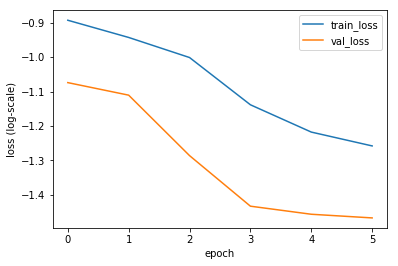

Epoch 7/25
125/400 [========>.....................] - ETA: 3:34 - loss: 0.0527

KeyboardInterrupt: 

In [160]:
history = model.fit(
    x=x_train[:400],
    y=x_train[:400],
#     x=x_train_trans[:400],
#     y=x_train[:400],
    batch_size=25,
    epochs=epochs, 
    validation_data=(x_val[:100], x_val[:100]),
#     validation_data=(x_val_trans[:100], x_val[:100]),
    callbacks=[plot_losses],
)

In [145]:
# history = model.fit(
# #     x=x_train[:400],
# #     y=x_train[:400],
#     x=x_train_trans,
#     y=x_train[:len(x_train_trans)],
#     batch_size=25,
#     epochs=epochs, 
#     validation_data=(x_val_trans, x_val[:len(x_val_trans)]),
#     callbacks=[plot_losses],
# )

In [ ]:
# model.evaluate(x=x_train[:400], y=x_train[:400])

In [157]:
# model.evaluate(x=x_val, y=x_val)

In [181]:
x_evaluate = x_train
# x_evaluate = x_val

# x_evaluate = x_train_trans
# x_evaluate = x_val_trans

idx = np.random.randint(len(x_evaluate))

x_in = x_evaluate[idx:idx+1]
x_trans = model_partial.predict(x_evaluate[idx:idx+1])
x_code = encoder.predict(x_trans)
x_out = model.predict(x_trans)

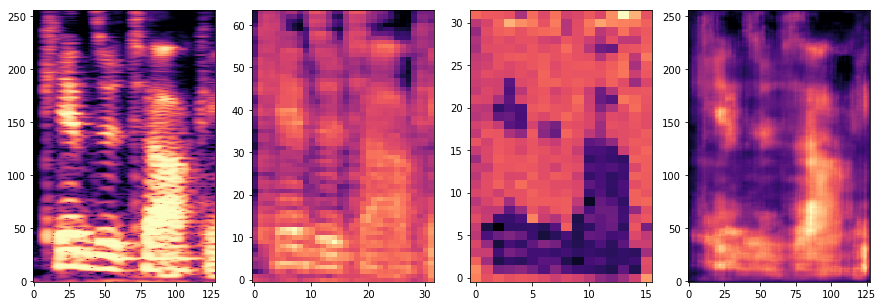

In [182]:
plt.figure(figsize=(15, 5))

plt.subplot(1,4,1)
plt.imshow(x_in[0, :, :, 0], origin='lower', aspect='auto', cmap=cmap_spec)

plt.subplot(1,4,2)
plt.imshow(x_trans[0, :, :, :].mean(-1), origin='lower', aspect='auto', cmap=cmap_spec)

plt.subplot(1,4,3)
plt.imshow(x_code[0, :, :, :].mean(-1), origin='lower', aspect='auto', cmap=cmap_spec)

plt.subplot(1,4,4)
plt.imshow(x_out[0, :, :, 0], origin='lower', aspect='auto', cmap=cmap_spec)

plt.show()

In [ ]:
# x_evaluate = x_train
x_evaluate = x_val

In [ ]:
x_in.shape

In [ ]:
x_trans[0, :, :, feat_axis].shape

In [ ]:
# x_in = x_evaluate[idx:idx+1]
# # x_in = (x_in - x_in.mean())/x_in.std()
# x_trans = model_partial.predict(x_evaluate[idx:idx+1])
# # x_trans = (x_trans - x_trans.mean())/x_trans.std()

plt.figure(figsize=(10, 5))

plt.subplot(1,3,1)
plt.imshow(x_in[0, :, :, :], origin='lower', aspect='auto')

plt.subplot(1,3,2)
# feat_axis = np.zeros(x_trans.shape[-1]).astype(bool)
# feat_axis[np.random.choice(range(10), 3)] = True
# plt.imshow(x_trans[0, :, :, feat_axis].transpose(1,2,0), origin='lower', aspect='auto')
plt.imshow(x_trans[0, :, :, :].mean(-1), origin='lower', aspect='auto')

# plt.subplot(1,3,3)
# plt.imshow(x_out[0, :, :, 0], origin='lower', aspect='auto', cmap=cmap_spec)

plt.show()

In [ ]:
x_feature = np.zeros(x_code.shape)
x_feature[0, 10, 10, 0] = 1

x_feature_decoded = 

In [ ]:
# model.summary()

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1,3,1)
plt.imshow(x_in[0, :, :, 0], origin='lower', aspect='auto', cmap=cmap_spec)

plt.subplot(1,3,2)
plt.imshow(x_code[0, :, :, 0:3], origin='lower', aspect='auto', cmap=cmap_spec)

plt.subplot(1,3,3)
plt.imshow(x_out[0, :, :, 0], origin='lower', aspect='auto', cmap=cmap_spec)

plt.show()